In [46]:
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pickle
from tensorflow import keras
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import matthews_corrcoef, f1_score

from colors import final_color, cv_color
from evaluation.serialization import Serializer
from constants import TYPES, annotation_mapping, reverse_annotation_mapping, amino_acid_mapping
from utils.encoding import sequenceToCategorical, categoricalToOneHot, categoricalToSequence, oneHotToCategorical
from utils.Dataset import Dataset
from utils.helpers import getDatasetPath

In [20]:
run_timestamp = "20211113-1438"
base_path = f"../../results/{run_timestamp}/"
final_model = keras.models.load_model(base_path + f"models/final_model.h5")


test_data = Dataset(getDatasetPath()).getFolds([0])


test_x = np.array([categoricalToOneHot(sequenceToCategorical(seq, amino_acid_mapping), amino_acid_mapping) for seq in test_data["sequence"]])
predictions = final_model.predict(test_x)

test_data["prediction"] = np.array([categoricalToSequence(oneHotToCategorical(pred), reverse_annotation_mapping) for pred in predictions])

In [21]:
def getRelevantData(query: str) -> Tuple[np.ndarray, np.ndarray]:
    relevant_data = test_data.query(query)
    y_pred = np.array([sequenceToCategorical(seq, annotation_mapping) for seq in relevant_data["prediction"]])
    y_true = np.array([sequenceToCategorical(seq, annotation_mapping) for seq in relevant_data["annotation"]])

    return (y_pred, y_true)

# Confusion Matrix for all Classes

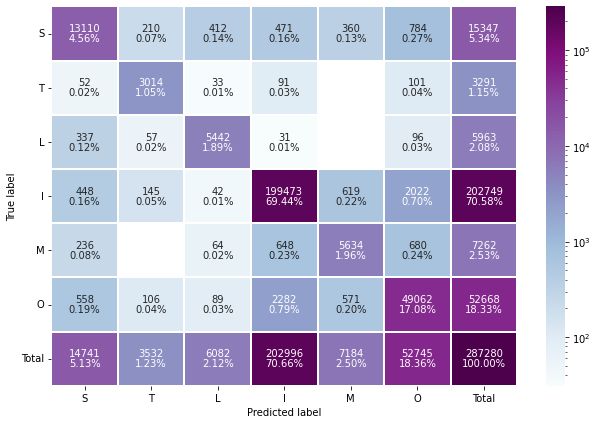

In [8]:
(y_pred, y_true) = getRelevantData("index == index")
fig, ax = plt.subplots(figsize=(15,12))

annotation_labels = [c for c in "STLIMO"]
cm = pd.DataFrame(
    confusion_matrix(y_true.flatten(), y_pred.flatten()),
    index = annotation_labels,
    columns = annotation_labels
)

# Add sum columns
cm.loc["Total", :] = cm.sum(axis=0)
cm.loc[:, "Total"] = cm.sum(axis=1)
cm = cm.astype(int)

# Create dataframe with relative values
cm_ratio = cm.applymap(lambda x: x / cm.loc["Total", "Total"])

# Absolute values
sns.heatmap(
    cm,
    annot=True, fmt="d",
    annot_kws={"va": "bottom"},
    linewidths=2,
    norm=matplotlib.colors.LogNorm(),
    cmap="BuPu",
    ax=ax
)

# Percentage values on top
sns.heatmap(
    cm_ratio,
    linewidths=2,
    annot=True,
    annot_kws={"va": "top"},
    fmt=".2%",
    norm=matplotlib.colors.LogNorm(),
    cmap="BuPu",
    cbar=False,
    ax=ax
)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
fig.set_size_inches(9, 6)
fig.tight_layout()
fig.savefig("output/confusion_matrix.png", dpi=240)

# Per-Class Confusion Matrices

In [ ]:
with open("../label_distribution.pickle", "rb") as f:
    proportions = pickle.load(f)


In [ ]:
titles = {
    'S': "Sec/SPI signal peptide",
    'T': "Tat/SPI signal peptide",
    'L': "Sec/SPII signal peptide",
    'I': "cytoplasm",
    'M': "transmembrane",
    'O': "extracellular"
}
matrices = multilabel_confusion_matrix(y_true.flatten(), y_pred.flatten())
annotation_labels = "True, False".split(", ")

for label, matrix in zip([c for c in "STLIMO"], matrices):
    fig, ax = plt.subplots()

    cm = pd.DataFrame(
        matrix,
        index = annotation_labels,
        columns = annotation_labels
    )

    # Add sum columns
    cm.loc["Total", :] = cm.sum(axis=0)
    cm.loc[:, "Total"] = cm.sum(axis=1)
    cm = cm.astype(int)

    # Create dataframe with relative values
    cm_ratio = cm.applymap(lambda x: x / cm.loc["Total", "Total"])

    # Absolute values
    sns.heatmap(
        cm.loc[["True", "False"], ["True", "False"]],
        annot=True, fmt="d",
        annot_kws={"va": "bottom"},
        linewidths=2,
        norm=matplotlib.colors.LogNorm(),
        cmap="BuPu",
        ax=ax
    )

    # Percentage values on top
    sns.heatmap(
        cm_ratio.loc[["True", "False"], ["True", "False"]],
        linewidths=2,
        annot=True,
        annot_kws={"va": "top"},
        fmt=".2%",
        norm=matplotlib.colors.LogNorm(),
        cmap="BuPu",
        cbar=False,
        ax=ax
    )
    ax.set_title(f"{titles[label]} ({label}) - {proportions[label]:.2%}")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    fig.set_size_inches(4, 3)
    fig.tight_layout()
    fig.savefig(f"output/confusion_matrix_{label}.png", dpi=240)
